In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
def activation_func(x):
    return 1 / (1 + np.exp(-x))
def derivative(x):
    return activation_func(x)*(1-activation_func(x))


class NN:
    def __init__(self, input_num=1, hidden=[2,3], output_num=1):
        self.input_num = input_num
        self.hidden = hidden
        self.output_num = output_num

        self.layers = [input_num] + hidden + [output_num]

        self.weights = []
        for i in range(len(self.layers)-1):
            stddev = np.sqrt(1 / self.layers[i])
            w = np.random.randn(self.layers[i], self.layers[i+1]) * stddev #Xavier
            self.weights.append(w)
        
        self.biases = [np.random.rand(1, self.layers[i+1]) for i in range(len(self.layers)-1)]
  
    
    def forward_propagation(self, input):
        self.activations =[input]
        self.zs =[input]
        for i in range(len(self.weights)):
            z = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
            self.zs.append(z)
            if i == len(self.weights)-1 :
                a = z
            else:
                a = activation_func(z)
            self.activations.append(a)
        return self.activations[-1]
    
    def backpropagate(self, y_pred, y, batch_gradients):
        #obliczenie błedów
        deltas = [(y_pred - y)]
        for i in reversed(range(len(self.weights))):
            deriv = derivative(self.zs[i])
            delta =  np.dot(deltas[0], self.weights[i].T) *deriv
            deltas.insert(0, delta)
        
        #obliczenie gradientow wag i biasów
        for i in range(len(self.weights)):
            dW = np.dot(np.array(self.activations[i]).T, deltas[i+1])
            batch_gradients[i]['dW'] += dW
            batch_gradients[i]['dB'] += deltas[i+1]
           

    def train(self, x,y, epochs=1000,  learning_rate=0.1, batch_size=32):
        X_train = np.array(x)
        y_train = np.array(y)

        for epoch in range(epochs):
            #losowe indeksy do batchy
            indices = np.arange(len(X_train))
            np.random.shuffle(indices)
            X_train, y_train = X_train[indices], y_train[indices]

            #inicjowanie gradientów
            batch_gradients = [
            {'dW': np.zeros_like(w), 'dB': np.zeros_like(b)} for w, b in zip(self.weights, self.biases)
            ]

            for i ,(sample_x, sample_y) in enumerate(zip(X_train, y_train)):
                y_hat = self.forward_propagation(sample_x)
                self.backpropagate(y_hat, sample_y,  batch_gradients)

                #aktualizacja wag na koniec batcha
                if (i + 1) % batch_size == 0 or (i + 1) == len(X_train):
                    for j in range(len(self.weights)):
                        self.weights[j] -= (learning_rate / batch_size) * batch_gradients[j]['dW']
                        self.biases[j] -= (learning_rate / batch_size) * batch_gradients[j]['dB']
                    
                    batch_gradients = [
                        {'dW': np.zeros_like(w), 'dB': np.zeros_like(b)} for w, b in zip(self.weights, self.biases)
                    ]

    def predict(self,x):
        return self.forward_propagation(x)
    
    def visualize_weights(self):
        fig, axes = plt.subplots(1, len(self.weights), figsize=(15, 5))

        for i, ax in enumerate(axes):
            weight_matrix = self.weights[i]
            cax = ax.matshow(weight_matrix, cmap='coolwarm')  # Tworzymy heatmapę
            fig.colorbar(cax, ax=ax)  # Dodajemy pasek kolorów
            ax.set_title(f'Layer {i} Weights')
            for (j, k), val in np.ndenumerate(weight_matrix):
                ax.text(k, j, f'{val:.2f}', ha='center', va='center', color='black', fontsize=8)

            ax.set_xlabel('Neurons in Next Layer')
            ax.set_ylabel('Neurons in Current Layer')

        plt.tight_layout()
        plt.show()
        
    




In [8]:
def normalize(data):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    return (data - min_val) / (max_val - min_val), min_val, max_val


def denormalize(data, min_val, max_val):
    return data * (max_val - min_val) + min_val



In [9]:
def train_until_target(nn, inputs_train, targets_train, inputs_test, targets_test, min_train_y, max_train_y,learning_rate=0.1, max_epochs=1000, mse_threshold=4, batch= 32):
    epoch = 0
    while epoch < max_epochs:
       
        nn.train(inputs_train, targets_train, epochs=1, learning_rate=learning_rate, batch_size=batch)
        predictions_test = nn.predict(inputs_test)

        predictions_denormalized = denormalize(predictions_test, min_train_y, max_train_y)
        mse_test = np.average((predictions_denormalized- targets_test)**2)
        
        if epoch%300 ==0:
            print(f"MSE on test data after epoch {epoch}: {mse_test}")
        
        if epoch%2500 == 0:
            plt.scatter(inputs_test, predictions_denormalized)
            plt.scatter(inputs_test, targets_test)
            plt.show()

            nn.visualize_weights()

        if mse_test < mse_threshold:
            print(f"Training stopped after {epoch} epochs with MSE = {mse_test}")
            break

        epoch += 1

## Square simple 

In [10]:
train_df = pd.read_csv('data/square-simple-training.csv')
test_df = pd.read_csv('data/square-simple-test.csv')
X_train = np.array(train_df['x'].tolist()).reshape(-1,1)
y_train = np.array(train_df['y'].tolist()).reshape(-1,1)
X_test = np.array(test_df['x'].tolist()).reshape(-1,1)
y_test = np.array(test_df['y'].tolist()).reshape(-1,1)

X_train_normalized, min_train_x, max_train_x = normalize(X_train)
y_train_normalized, min_train_y, max_train_y = normalize(y_train)

X_test_normalized, min_test_x, max_test_x = normalize(X_test)

MSE on test data after epoch 0: 7851.0101857846485


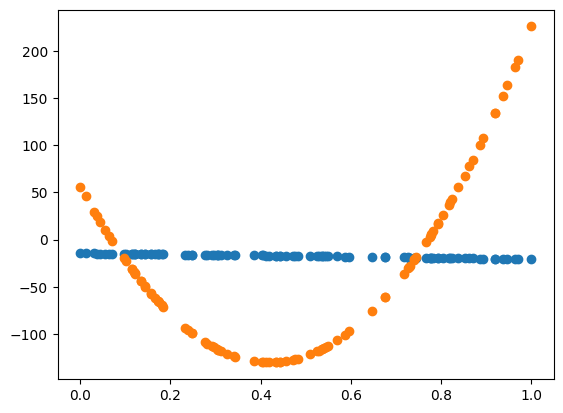

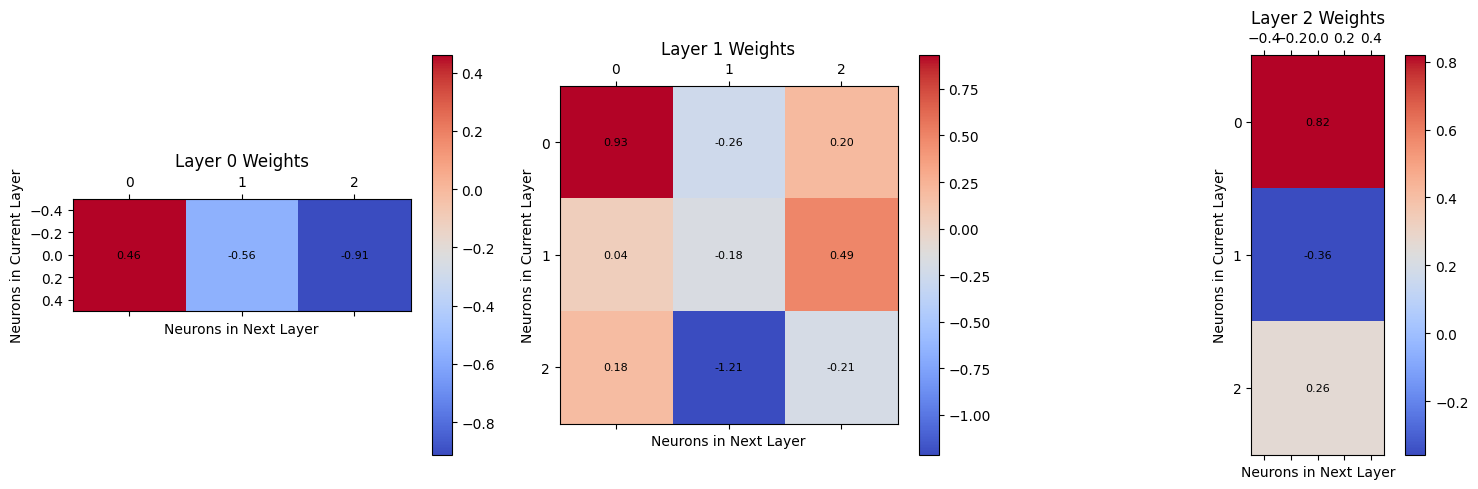

MSE on test data after epoch 300: 7324.691237008961
MSE on test data after epoch 600: 6335.100286298595
MSE on test data after epoch 900: 5527.62467156077
MSE on test data after epoch 1200: 5131.255031394545
MSE on test data after epoch 1500: 4732.609562132579
MSE on test data after epoch 1800: 4355.86771584879
MSE on test data after epoch 2100: 3817.4198727711455
MSE on test data after epoch 2400: 3344.9673186158047


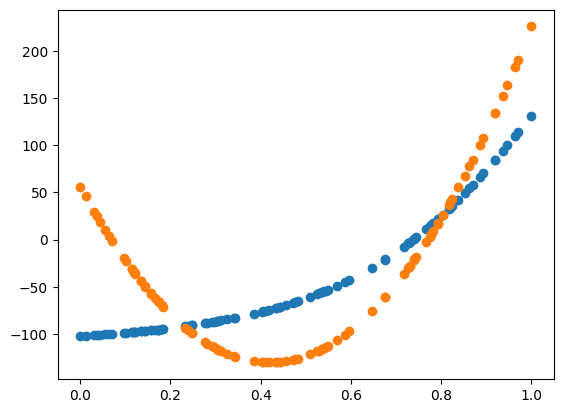

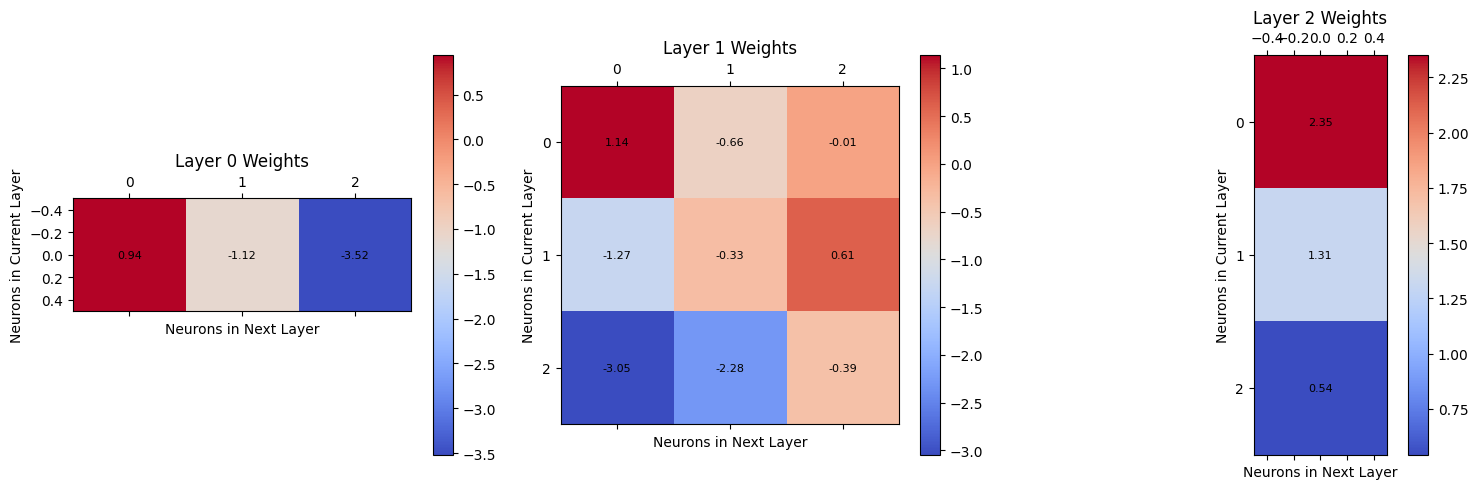

MSE on test data after epoch 2700: 2872.6158830793343
MSE on test data after epoch 3000: 2321.012282411683
MSE on test data after epoch 3300: 1543.9480663552015
MSE on test data after epoch 3600: 669.2087215652512
MSE on test data after epoch 3900: 379.5125755412921
MSE on test data after epoch 4200: 257.4323849782291
MSE on test data after epoch 4500: 208.15912278248453
MSE on test data after epoch 4800: 178.54642437981744


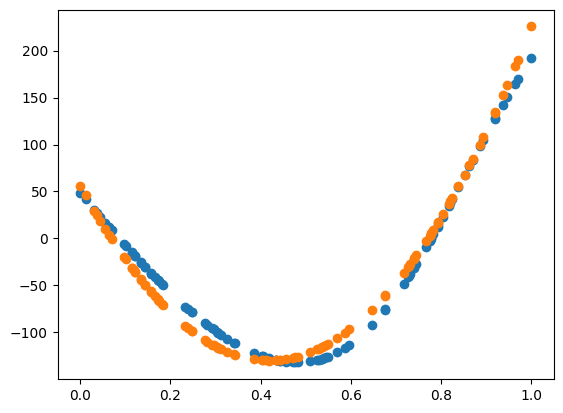

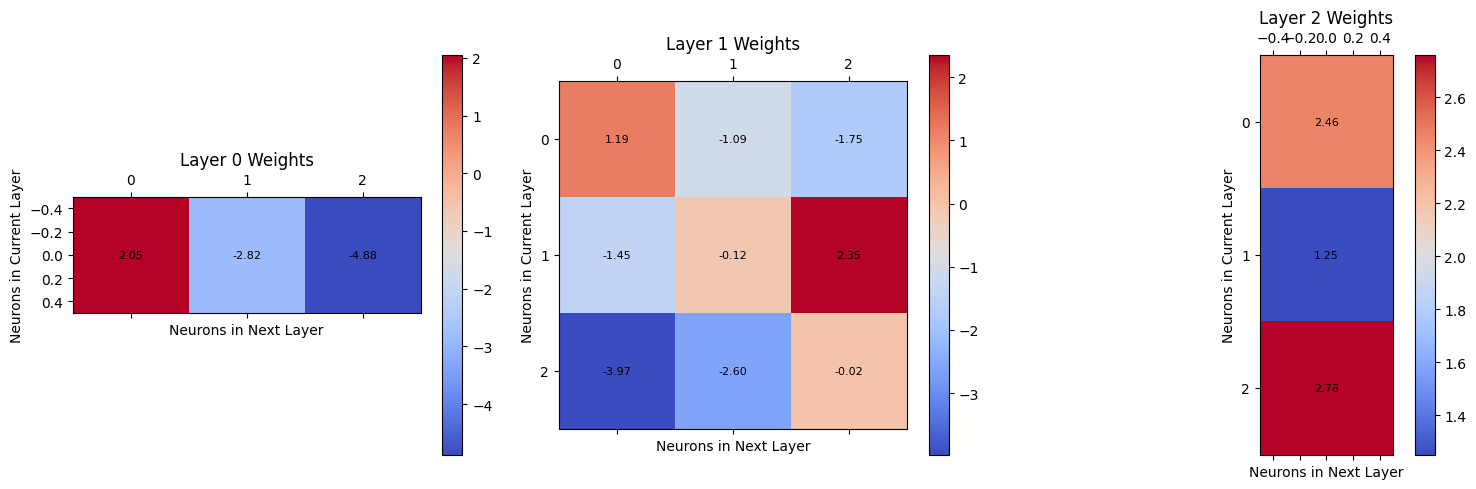

MSE on test data after epoch 5100: 166.93471132809066
MSE on test data after epoch 5400: 156.26280013112927
MSE on test data after epoch 5700: 147.6901126259421
MSE on test data after epoch 6000: 140.68583493913525
MSE on test data after epoch 6300: 134.58857877843926
MSE on test data after epoch 6600: 128.60038193911456
MSE on test data after epoch 6900: 124.68127603442376
MSE on test data after epoch 7200: 119.15273188455458
MSE on test data after epoch 7500: 115.77673091625762


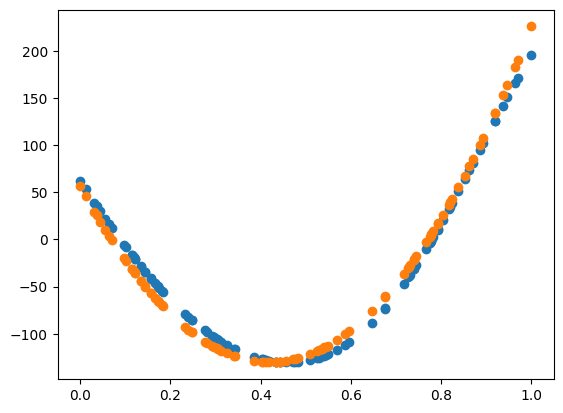

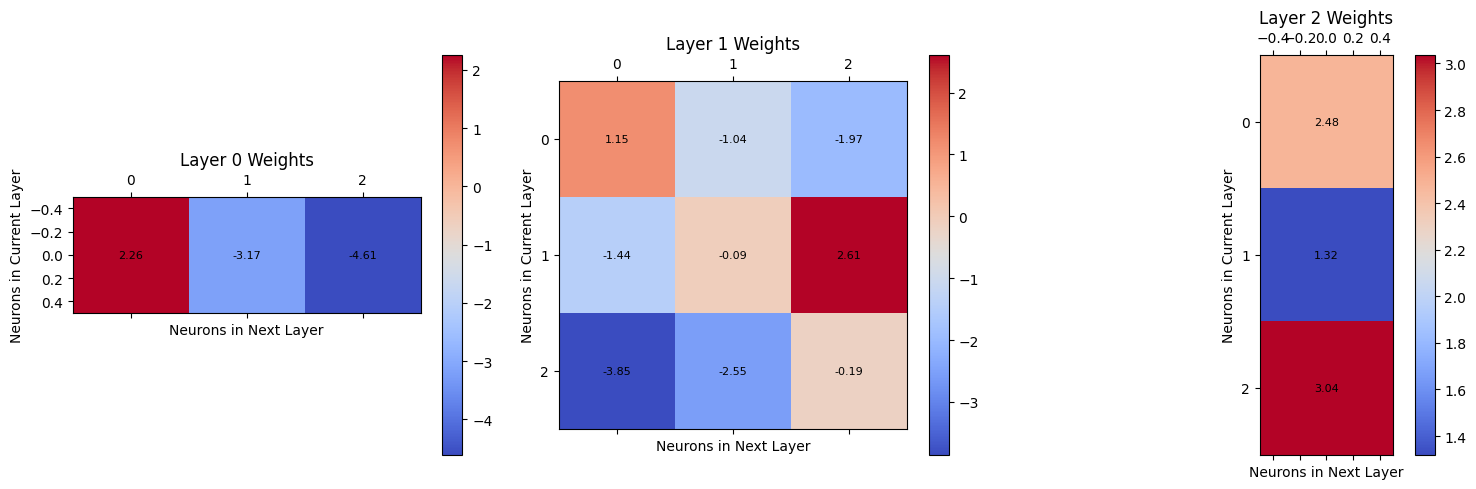

MSE on test data after epoch 7800: 112.2983937470517
MSE on test data after epoch 8100: 109.64028697142803
MSE on test data after epoch 8400: 107.47925831917135
MSE on test data after epoch 8700: 104.98974386505449
MSE on test data after epoch 9000: 103.01620669682632
MSE on test data after epoch 9300: 101.09034758174026
MSE on test data after epoch 9600: 99.27514505279278
MSE on test data after epoch 9900: 97.7589973547246


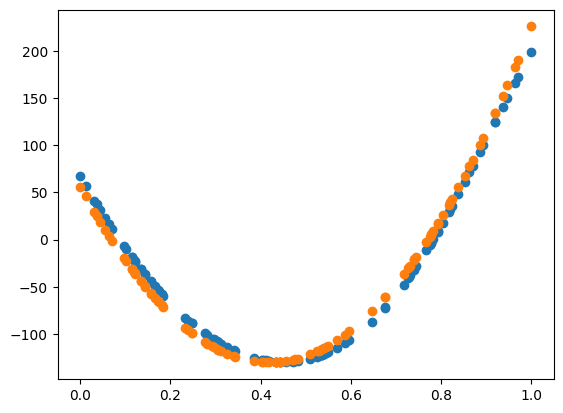

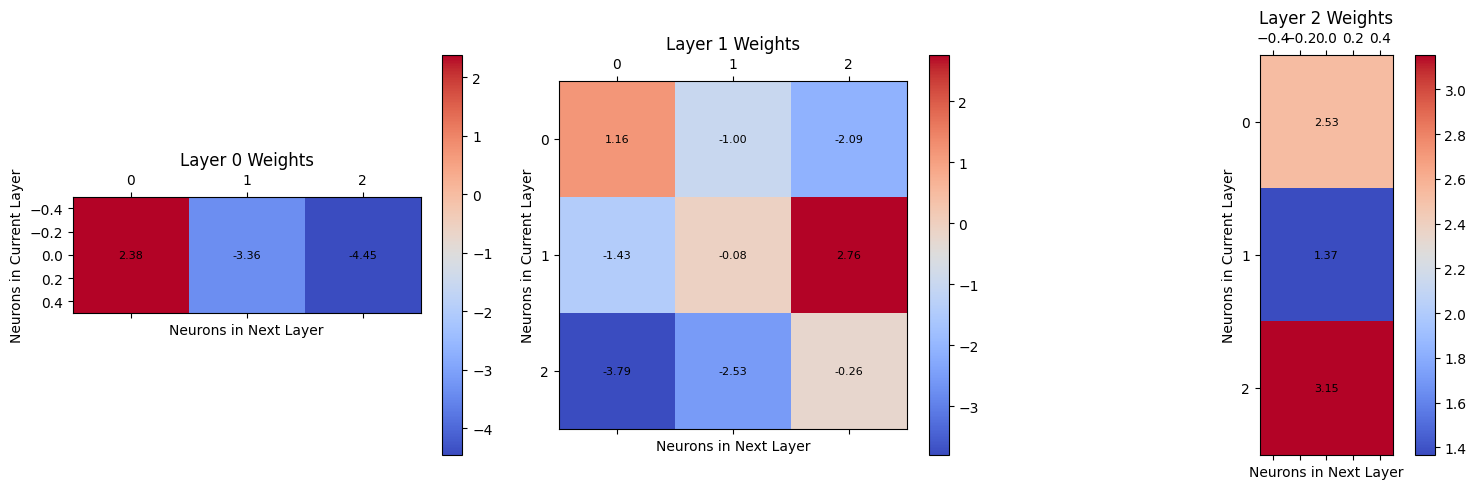

MSE on test data after epoch 10200: 96.61630861151365
MSE on test data after epoch 10500: 95.48805157434222
MSE on test data after epoch 10800: 94.32047365784025
MSE on test data after epoch 11100: 93.4288178730855
MSE on test data after epoch 11400: 93.12672093364637
MSE on test data after epoch 11700: 92.19571211739358
MSE on test data after epoch 12000: 91.57369074877724
MSE on test data after epoch 12300: 90.89428518915089


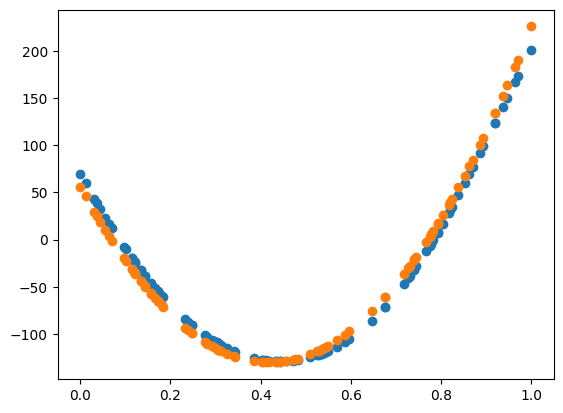

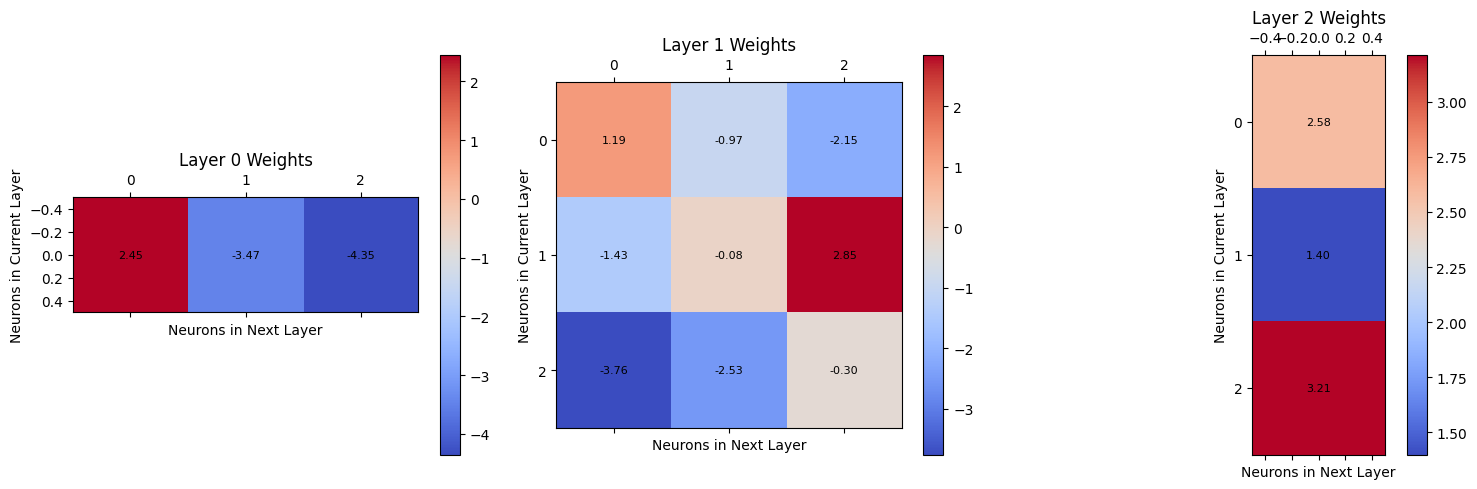

MSE on test data after epoch 12600: 90.39413555558808
MSE on test data after epoch 12900: 89.76169534125864
MSE on test data after epoch 13200: 89.45681353557269
MSE on test data after epoch 13500: 89.42267942215643
MSE on test data after epoch 13800: 88.87299332039848
MSE on test data after epoch 14100: 88.3706312490665
MSE on test data after epoch 14400: 88.44210083623103
MSE on test data after epoch 14700: 87.96586803410182
MSE on test data after epoch 15000: 87.89471672593949


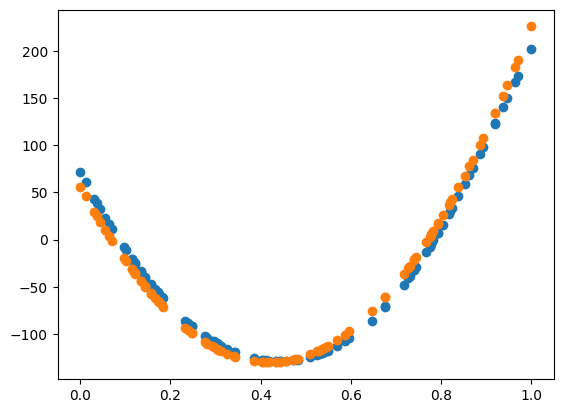

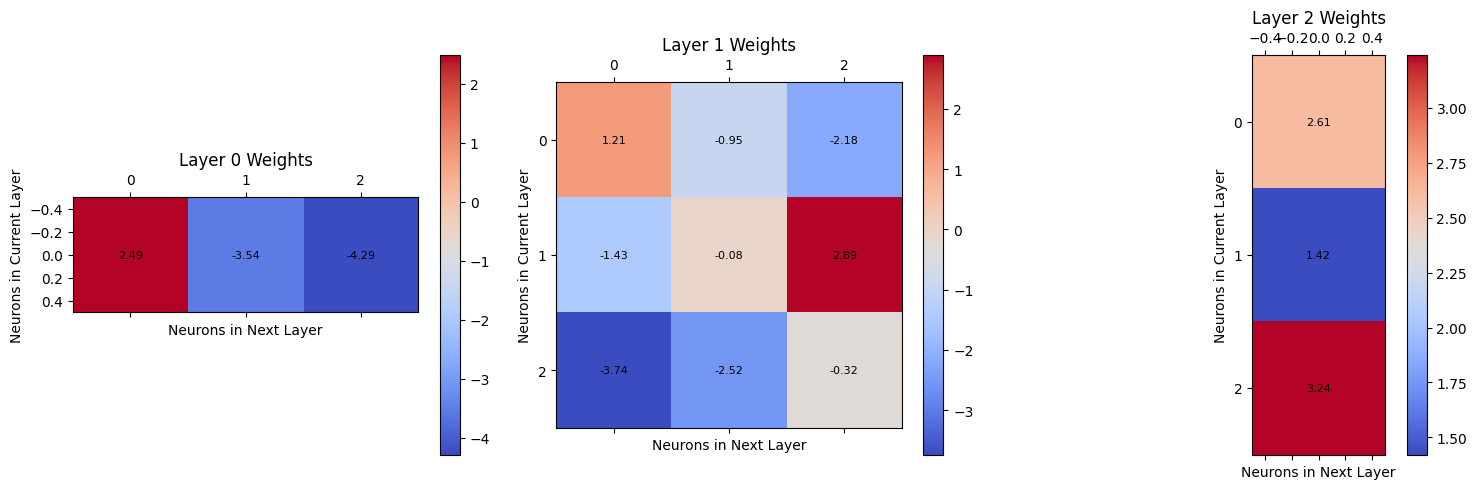

MSE on test data after epoch 15300: 87.38491011361619
MSE on test data after epoch 15600: 87.27159046719123
MSE on test data after epoch 15900: 87.39261676282099
MSE on test data after epoch 16200: 86.83127357953684
MSE on test data after epoch 16500: 86.88598914132758
MSE on test data after epoch 16800: 87.05571040251257
MSE on test data after epoch 17100: 87.00568956928385
MSE on test data after epoch 17400: 86.75048968024358


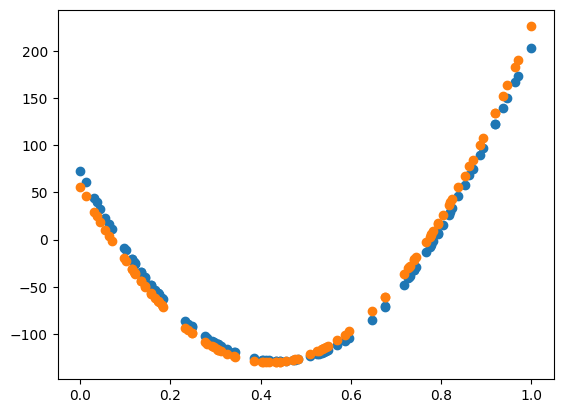

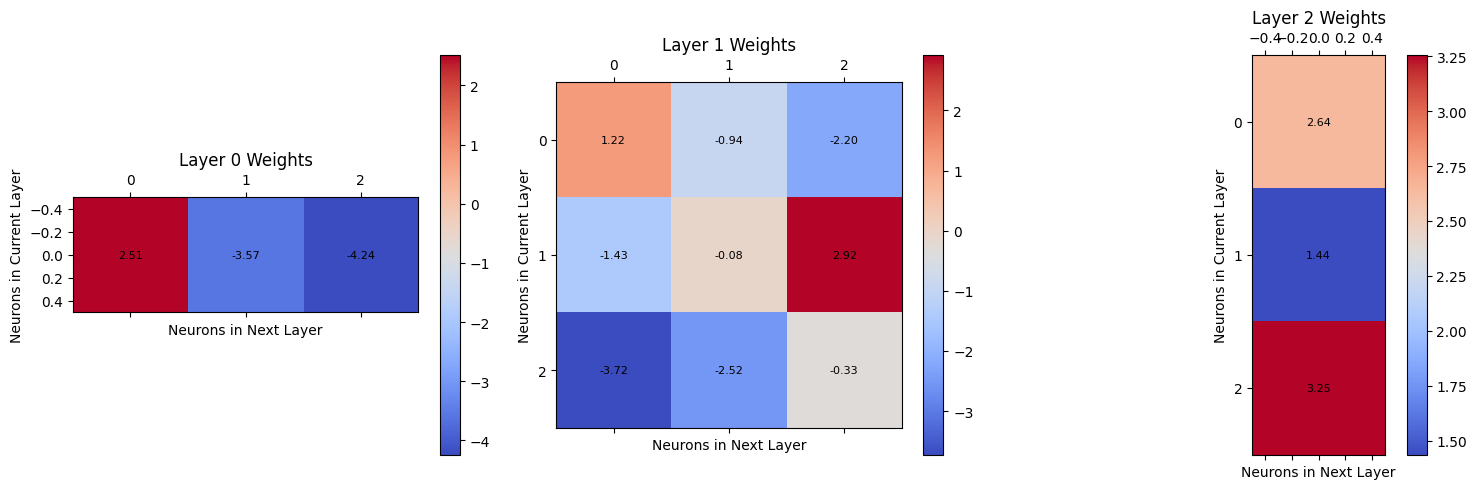

MSE on test data after epoch 17700: 86.73501127611382
MSE on test data after epoch 18000: 86.79967639470476
MSE on test data after epoch 18300: 86.65084197338393
MSE on test data after epoch 18600: 86.54657633087399
MSE on test data after epoch 18900: 86.25221454824478
MSE on test data after epoch 19200: 86.45199115649538
MSE on test data after epoch 19500: 86.62443862746225
MSE on test data after epoch 19800: 86.67566229324412


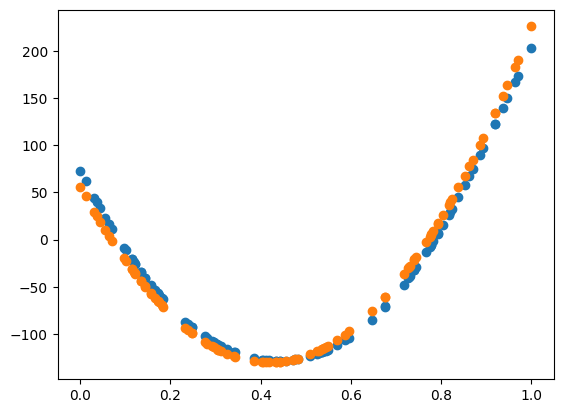

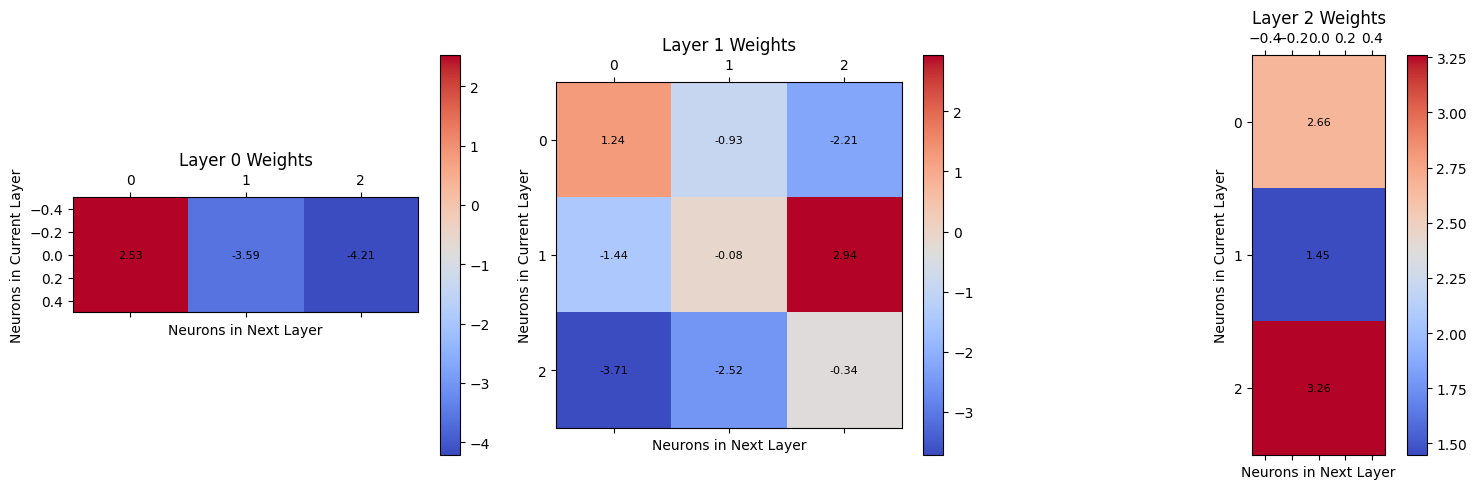

MSE on test data after epoch 20100: 86.50506752662072
MSE on test data after epoch 20400: 86.40318404836587
MSE on test data after epoch 20700: 86.3783720489665
MSE on test data after epoch 21000: 86.44270679919299
MSE on test data after epoch 21300: 86.54211274146263
MSE on test data after epoch 21600: 86.38960046890844
MSE on test data after epoch 21900: 86.28094528845718
MSE on test data after epoch 22200: 86.18044683683718
MSE on test data after epoch 22500: 86.36610501577479


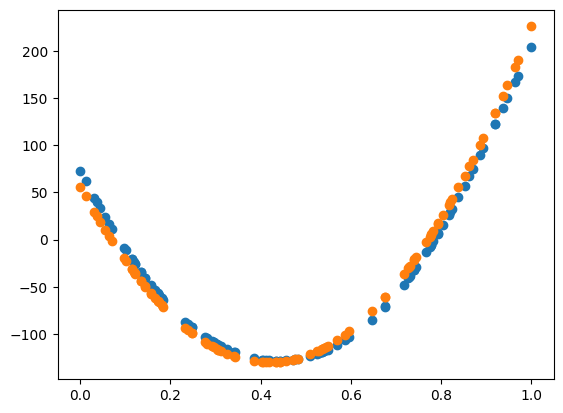

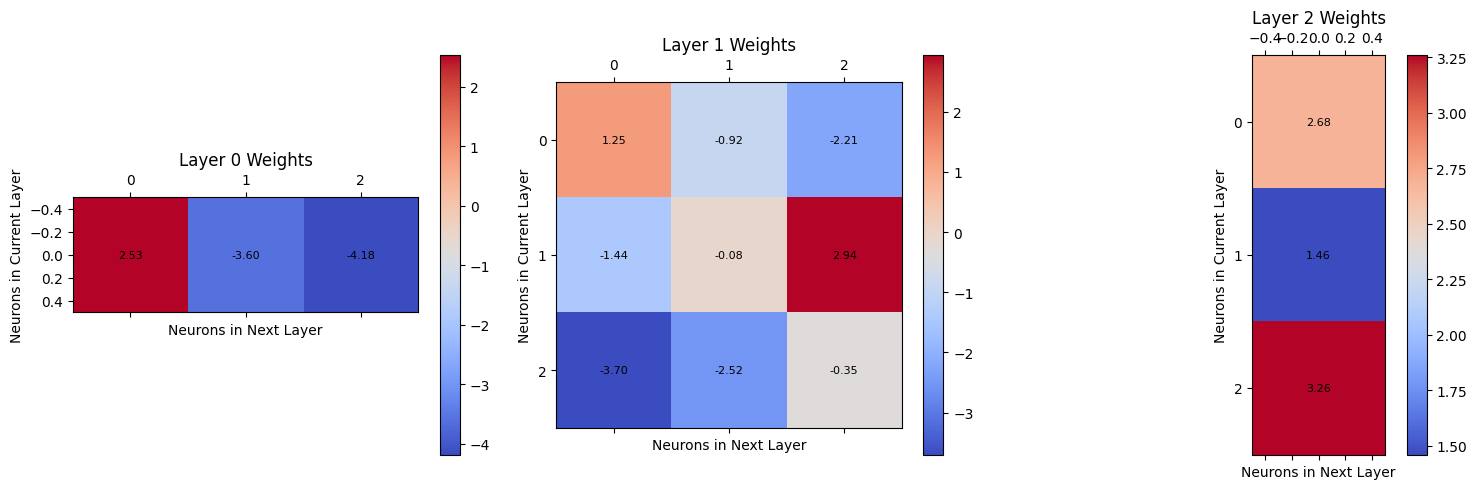

MSE on test data after epoch 22800: 86.58336368020814
MSE on test data after epoch 23100: 86.44139379849312
MSE on test data after epoch 23400: 86.46702777123139
MSE on test data after epoch 23700: 86.51847718322888
MSE on test data after epoch 24000: 86.70933194008065
MSE on test data after epoch 24300: 86.46112930809205
MSE on test data after epoch 24600: 86.63286504844295
MSE on test data after epoch 24900: 86.60493467729282


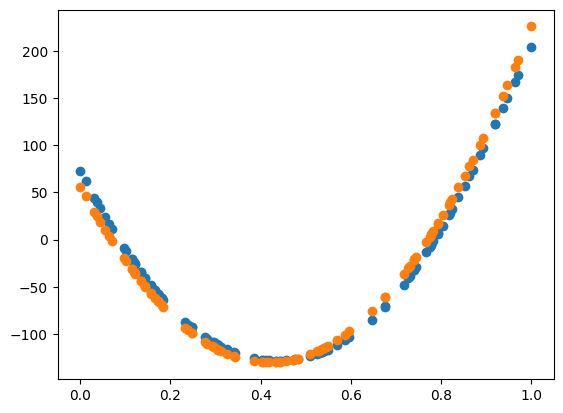

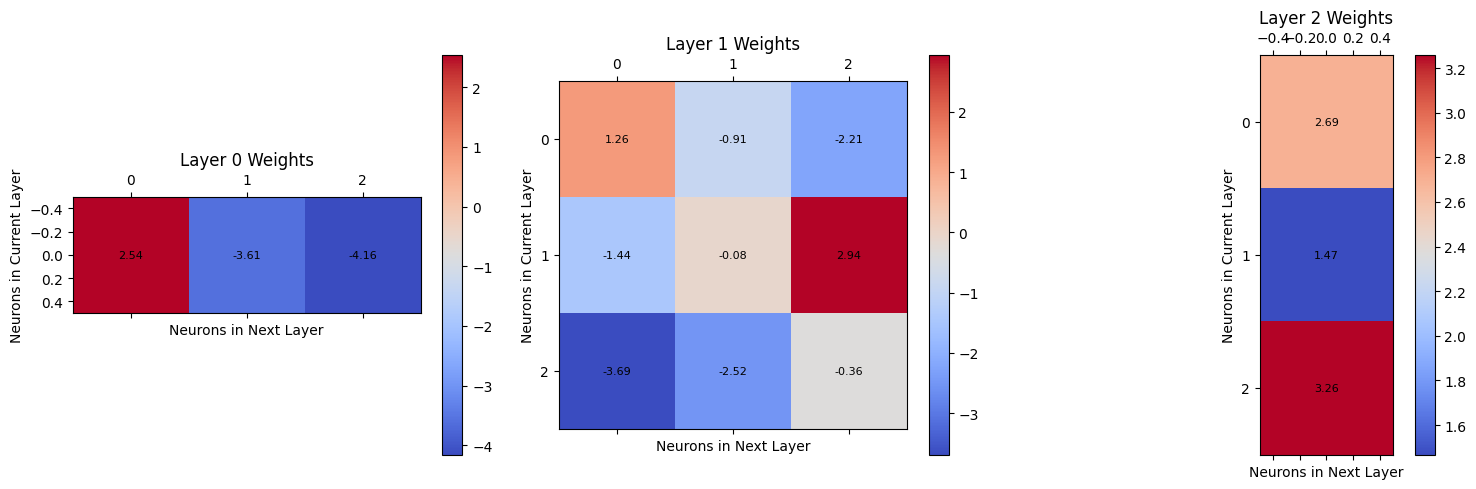

MSE on test data after epoch 25200: 86.39337002961638
MSE on test data after epoch 25500: 86.30443745146266
MSE on test data after epoch 25800: 86.81607597637802
MSE on test data after epoch 26100: 86.89519413201079
MSE on test data after epoch 26400: 86.43013926404831
MSE on test data after epoch 26700: 86.5602462825199
MSE on test data after epoch 27000: 86.67803537037851
MSE on test data after epoch 27300: 86.46689390642912


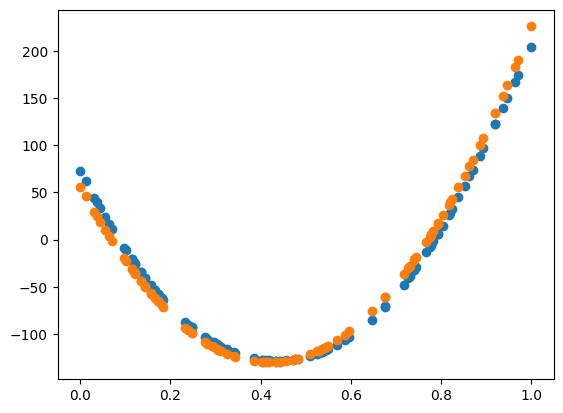

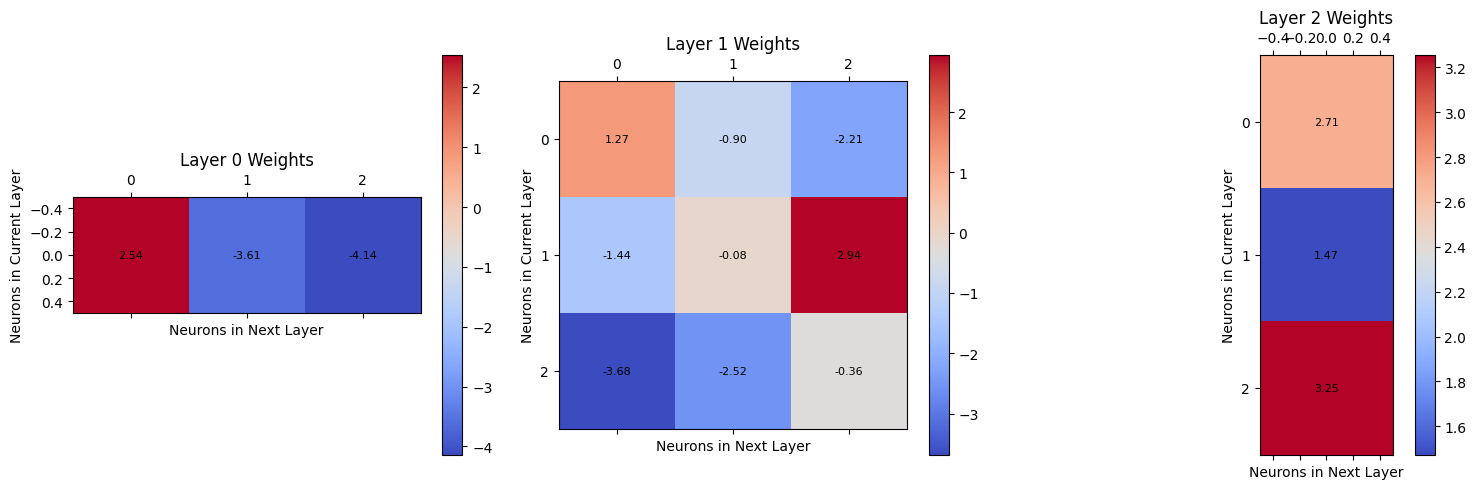

MSE on test data after epoch 27600: 86.80700428860357
MSE on test data after epoch 27900: 86.49942209125791
MSE on test data after epoch 28200: 86.54117296275271
MSE on test data after epoch 28500: 86.9950766444329
MSE on test data after epoch 28800: 87.05297292020877
MSE on test data after epoch 29100: 87.27655234381355
MSE on test data after epoch 29400: 87.2657716584598
MSE on test data after epoch 29700: 86.989234827701


In [12]:
nn = NN(input_num=1, hidden=[3,3], output_num=1)

train_until_target(nn, X_train_normalized, y_train_normalized, X_test_normalized, y_test,min_train_y, max_train_y, 0.25, 30000, 4 , batch=32)


We can see that network is learning but for some reason can't go past MSE 85.

## Multimodal large

In [23]:
train_df = pd.read_csv('data/multimodal-large-training.csv')
test_df = pd.read_csv('data/multimodal-large-test.csv')
train_df = train_df.sample(frac =0.5)
test_df = test_df.sample(frac=0.5)

X_train = np.array(train_df['x'].tolist()).reshape(-1,1)
y_train = np.array(train_df['y'].tolist()).reshape(-1,1)
X_test = np.array(test_df['x'].tolist()).reshape(-1,1)
y_test = np.array(test_df['y'].tolist()).reshape(-1,1)

X_train_normalized, min_train_x, max_train_x = normalize(X_train)
y_train_normalized, min_train_y, max_train_y = normalize(y_train)

X_test_normalized, min_test_x, max_test_x = normalize(X_test)

MSE on test data after epoch 0: 5550.685721757575


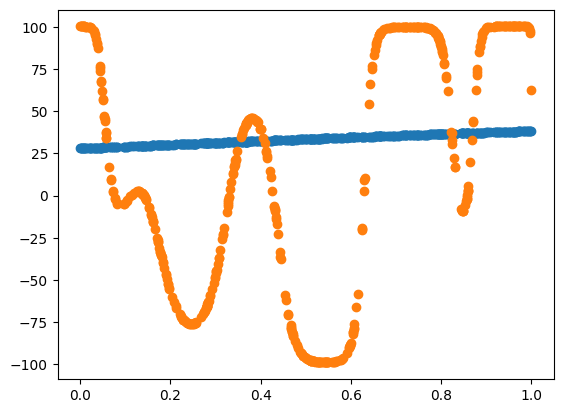

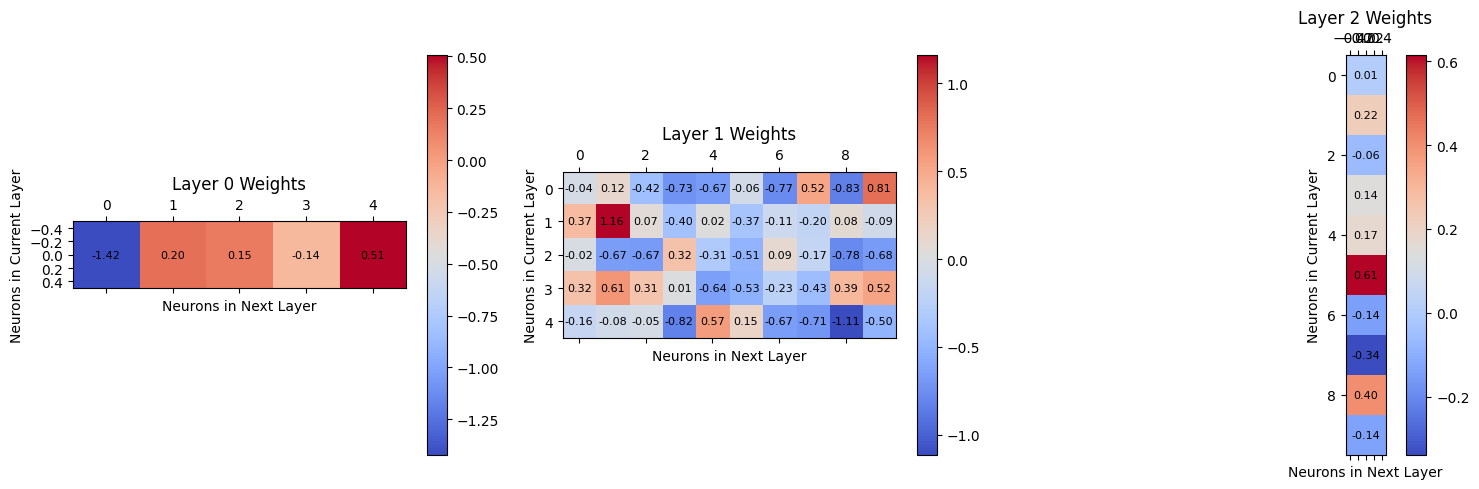

MSE on test data after epoch 300: 2465.800621056055
MSE on test data after epoch 600: 823.9090089709529
MSE on test data after epoch 900: 652.8508385212657
MSE on test data after epoch 1200: 569.6509885595848
MSE on test data after epoch 1500: 609.622686701888
MSE on test data after epoch 1800: 461.0390454256077
MSE on test data after epoch 2100: 423.55570159139205
MSE on test data after epoch 2400: 397.99021863850567


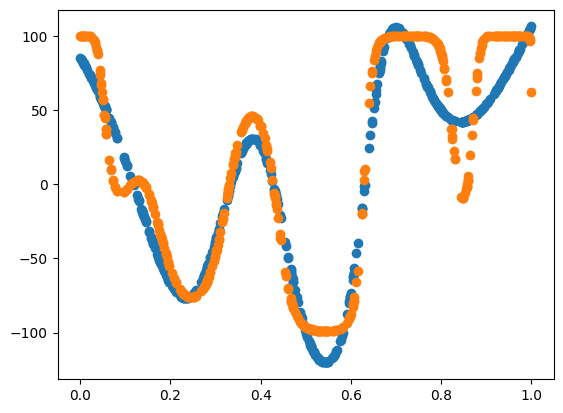

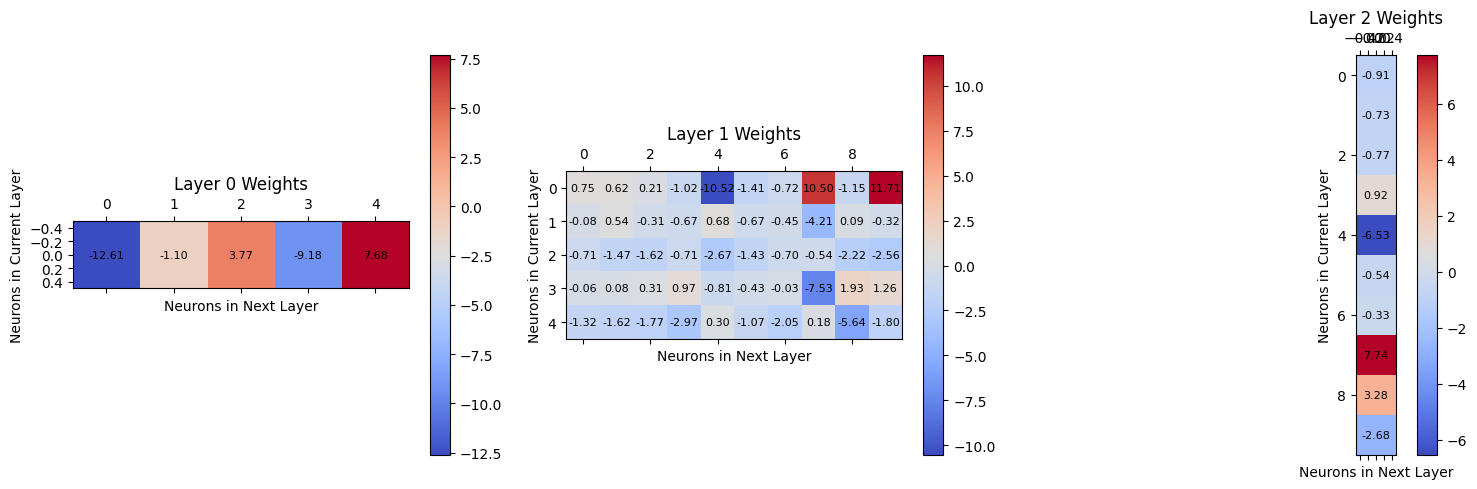

MSE on test data after epoch 2700: 376.78747015757915
MSE on test data after epoch 3000: 398.19971678283025
MSE on test data after epoch 3300: 360.6220398253682
MSE on test data after epoch 3600: 349.9960920537541
MSE on test data after epoch 3900: 348.5170020078187
MSE on test data after epoch 4200: 335.9633263186346
MSE on test data after epoch 4500: 326.7725619039751
MSE on test data after epoch 4800: 333.42334636469104


In [24]:
nn = NN(input_num=1, hidden=[5,10], output_num=1)

train_until_target(nn, X_train_normalized, y_train_normalized, X_test_normalized, y_test,min_train_y, max_train_y, 0.5, 5000, 40 , batch=64)


## Steps Small 

In [18]:
train_df = pd.read_csv('data/steps-small-training.csv')
test_df = pd.read_csv('data/steps-small-test.csv')
X_train = np.array(train_df['x'].tolist()).reshape(-1,1)
y_train = np.array(train_df['y'].tolist()).reshape(-1,1)
X_test = np.array(test_df['x'].tolist()).reshape(-1,1)
y_test = np.array(test_df['y'].tolist()).reshape(-1,1)

X_train_normalized, min_train_x, max_train_x = normalize(X_train)
y_train_normalized, min_train_y, max_train_y = normalize(y_train)

X_test_normalized, min_test_x, max_test_x = normalize(X_test)

MSE on test data after epoch 0: 10096.447793300644


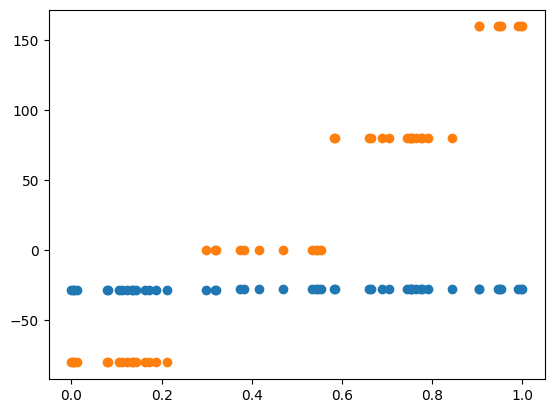

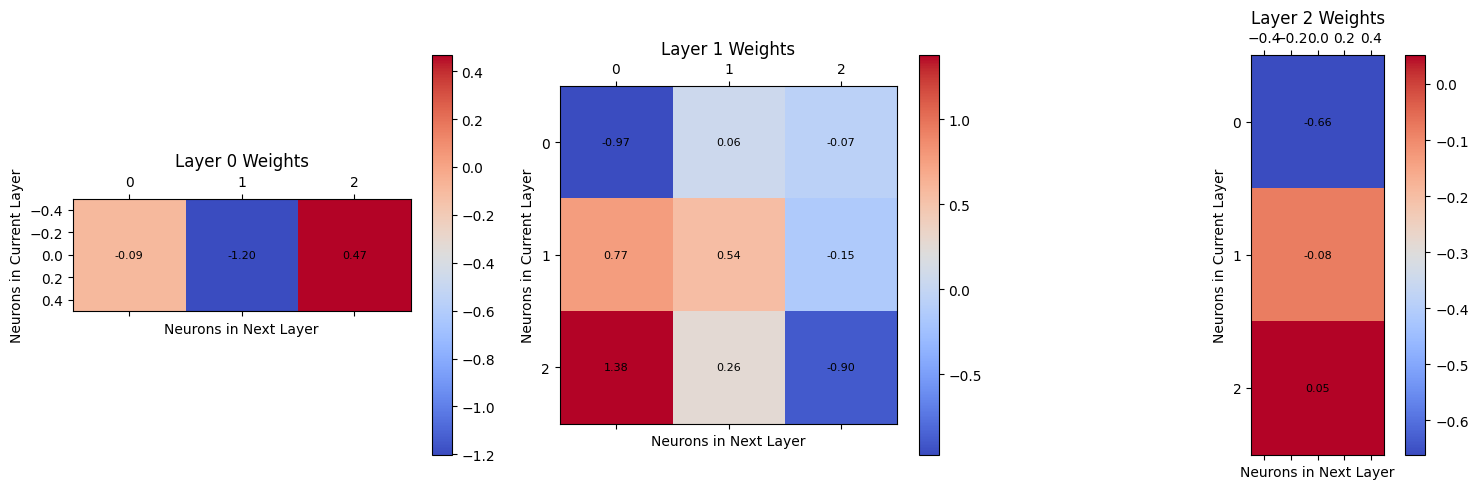

MSE on test data after epoch 300: 6616.3791657063
MSE on test data after epoch 600: 2207.612974221956
MSE on test data after epoch 900: 491.7516163863263
MSE on test data after epoch 1200: 446.26236549514584
MSE on test data after epoch 1500: 423.10996570933844
MSE on test data after epoch 1800: 407.9898188021578
MSE on test data after epoch 2100: 397.878445976756
MSE on test data after epoch 2400: 390.94118623980694


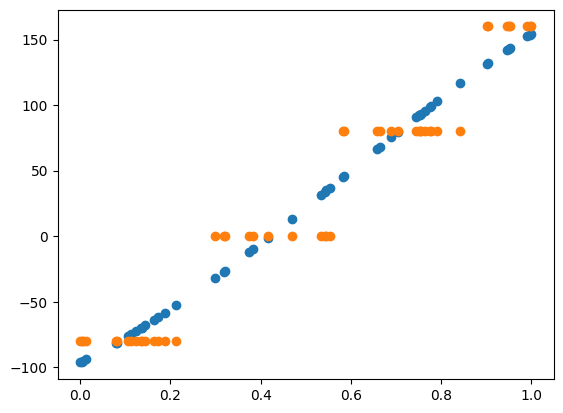

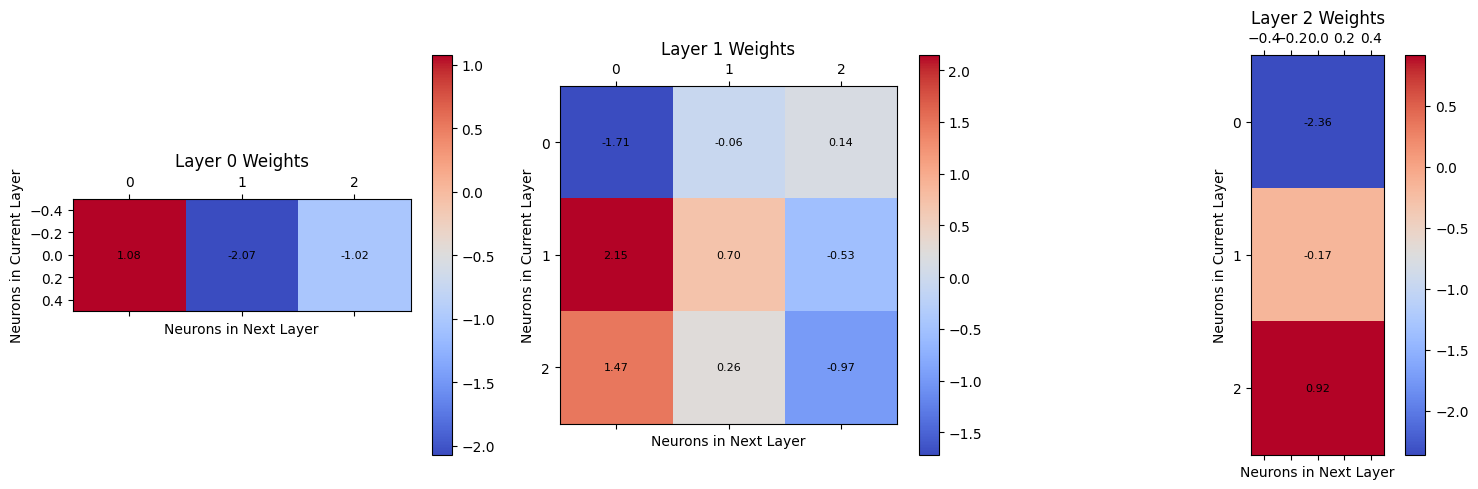

MSE on test data after epoch 2700: 387.56595629310397
MSE on test data after epoch 3000: 384.0816734619416
MSE on test data after epoch 3300: 381.062266560751
MSE on test data after epoch 3600: 377.9098521276469
MSE on test data after epoch 3900: 376.28573137076404
MSE on test data after epoch 4200: 376.8556227569372
MSE on test data after epoch 4500: 374.0998038259746
MSE on test data after epoch 4800: 374.22203709950355


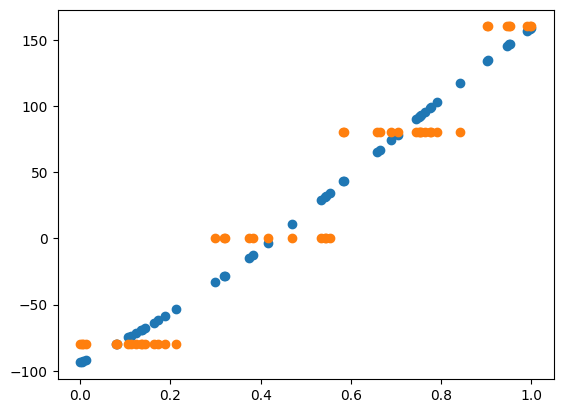

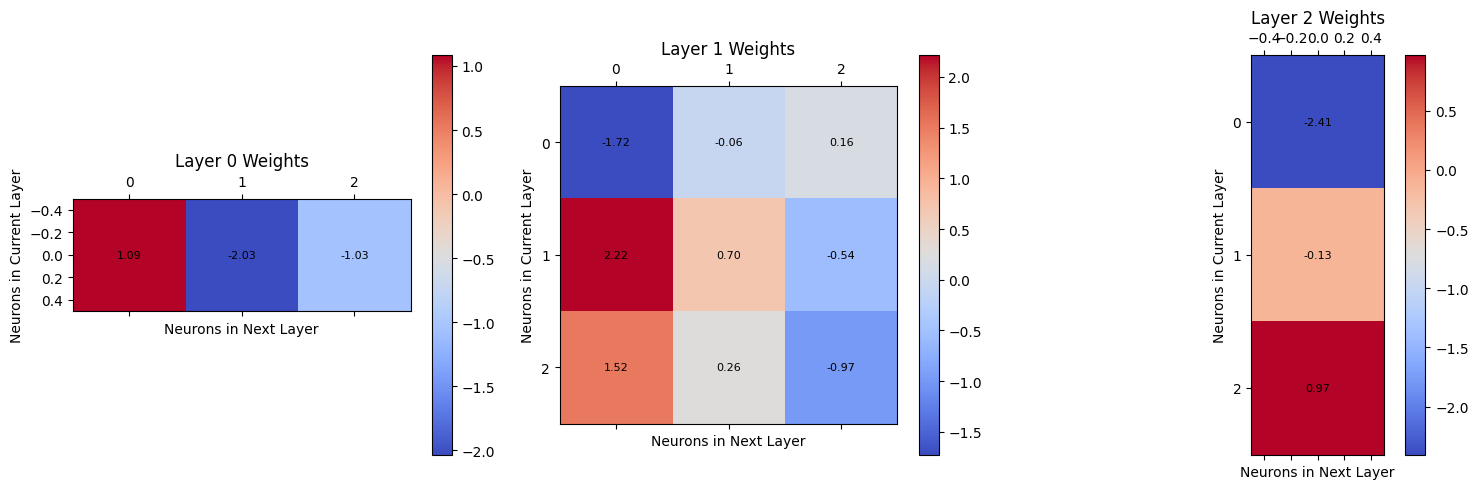

MSE on test data after epoch 5100: 373.289752075101
MSE on test data after epoch 5400: 372.9977048450502
MSE on test data after epoch 5700: 372.7466045995958
MSE on test data after epoch 6000: 372.17079387169264
MSE on test data after epoch 6300: 372.24802309302703
MSE on test data after epoch 6600: 371.2238676089577
MSE on test data after epoch 6900: 371.5515436048783
MSE on test data after epoch 7200: 372.1968122027289
MSE on test data after epoch 7500: 372.14847145720427


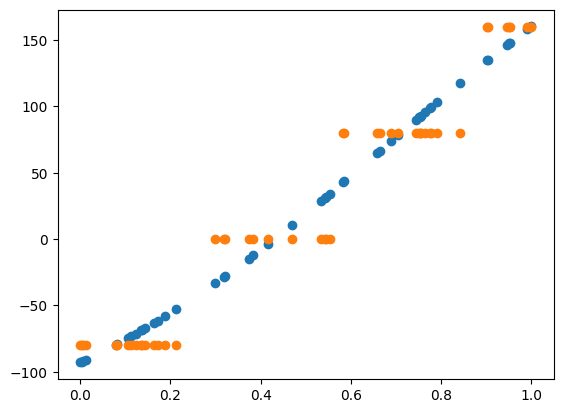

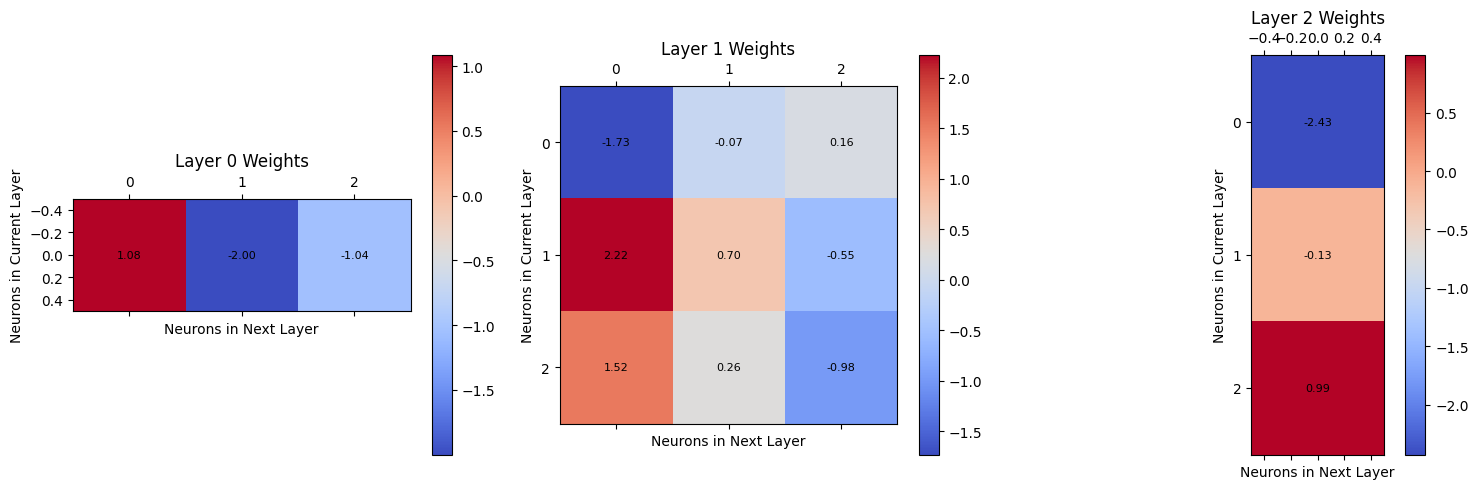

MSE on test data after epoch 7800: 369.97051879144726
MSE on test data after epoch 8100: 372.4546270431338
MSE on test data after epoch 8400: 370.1992630725436
MSE on test data after epoch 8700: 370.4007437972381
MSE on test data after epoch 9000: 371.89187019011956
MSE on test data after epoch 9300: 370.3958415768504
MSE on test data after epoch 9600: 371.85801177723073
MSE on test data after epoch 9900: 369.75002188178127


In [20]:
nn = NN(input_num=1, hidden=[3,3], output_num=1)

train_until_target(nn, X_train_normalized, y_train_normalized, X_test_normalized, y_test,min_train_y, max_train_y, 0.2, 10000, 4 , batch=32)
